In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from SmartPlotter import *
from PIL import Image
import os

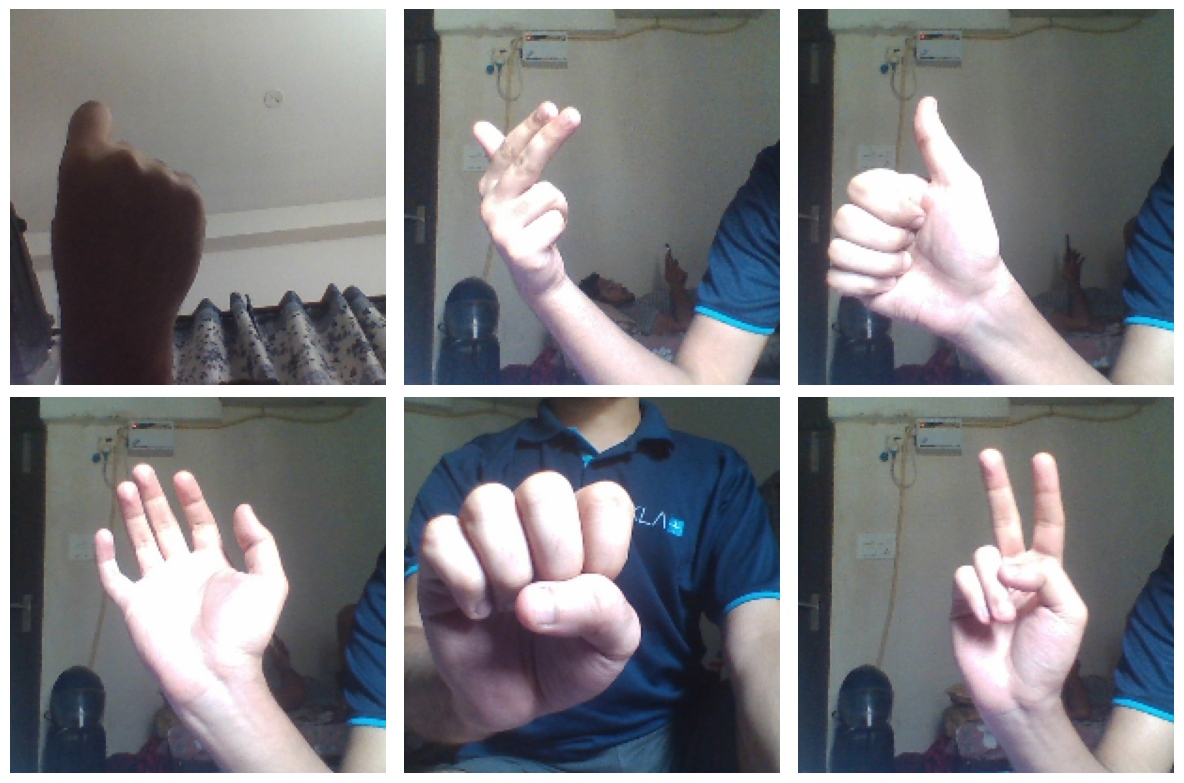

In [2]:
sample_imgs_path = './sample_images/'
im2show = []
for i in range(len(os.listdir(sample_imgs_path))-1,-1,-1):
    img = Image.open(sample_imgs_path+str(i)+'.jpg')
    img = np.asarray(img)
    h, w = img.shape[:2]
    crop = (w-h)//2
    img = img[:,crop:-crop]
    img = cv2.resize(img, (200, 200))
    im2show.append(img)

SmartPlot(im2show)
plt.show()

In [3]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

2023-06-25 18:52:15.622439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


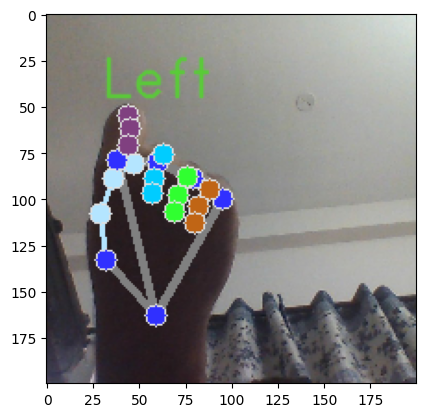

In [4]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
mpImg = mp.Image(image_format=mp.ImageFormat.SRGB, data=im2show[0])
detection_result = detector.detect(mpImg)


# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(mpImg.numpy_view(), detection_result)
plt.imshow(annotated_image)
plt.show()

24 100 50 168


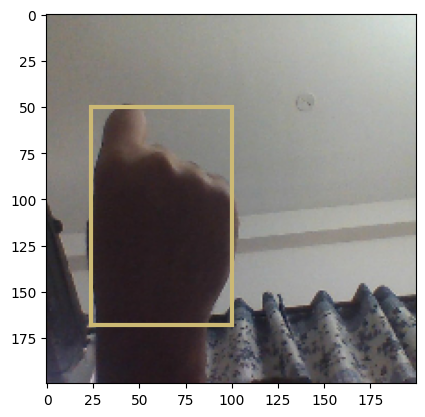

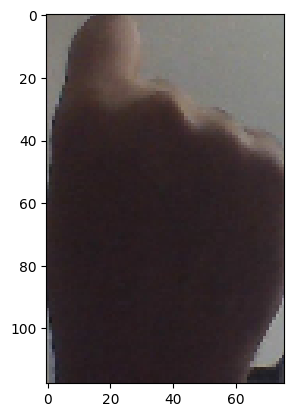

In [5]:
xs, ys = [], []
for coord in detection_result.hand_landmarks[0]:
    xs.append(coord.x)
    ys.append(coord.y)
xmin = int(min(xs)*200-5)
xmax = int(max(xs)*200+5)
ymin = int(min(ys)*200-5)
ymax = int(max(ys)*200+5)



print(xmin, xmax, ymin, ymax)

fig, ax = plt.subplots()
img = im2show[0]
ax.imshow(img)
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=3, edgecolor='y', facecolor='#00000000')
ax.add_patch(rect)
plt.show()

cropped_img = im2show[0][ymin:ymax,xmin:xmax]
plt.imshow(cropped_img)
plt.show()


In [6]:
from skimage import img_as_float

cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
cropped_img = img_as_float(cropped_img)

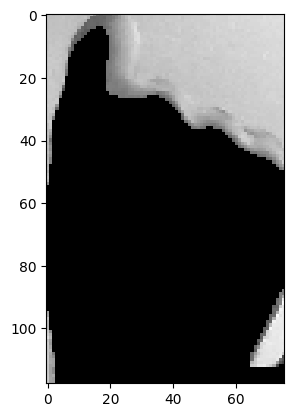

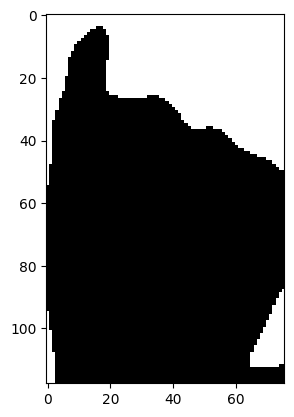

In [7]:
from skimage.segmentation import chan_vese

cv = chan_vese(cropped_img, mu=0.15, lambda1=.75, lambda2=.6, tol=1e-5,
               max_num_iter=500, dt=0.5, init_level_set="checkerboard",
               extended_output=True)
plt.imshow((1-cv[0])*(cropped_img), cmap='gray')
plt.show()
plt.imshow((1-cv[0]), cmap='gray')
plt.show()

2023-06-25 18:58:45.538212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 142ms/step


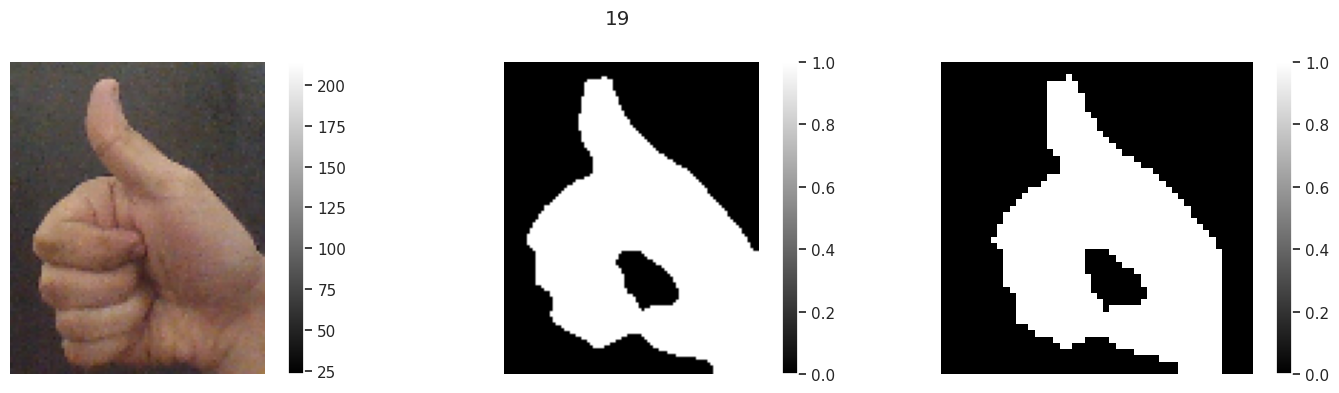

In [10]:
# Checking the functions
from preprocess import *
from PIL import Image
from SmartPlotter import *
import tensorflow as tf

model = tf.keras.models.load_model('./SavedModel_1/')

img = Image.open('sample_images/6.jpg')
img = np.array(img)
img = sq_crop(img)
img = cv2.resize(img, (200,200))
HANDMARKER = HandMarker()
xmin, xmax, ymin, ymax = HANDMARKER.give_box(img)
img = img[ymin:ymax, xmin:xmax]
mask = bin_mask(img)
mask_padded = sq_pad(mask)
mask_50x50 = cv2.resize(mask_padded, (50, 50))

mask_50x50[mask_50x50<0.5] = 0
mask_50x50[mask_50x50>0.5] = 1
pred = np.argmax(model.predict(mask_50x50[None,:,:,None])[0])
SmartPlot([img, mask, mask_50x50], colorbar=True, fig_sup_title=f'{pred}')
plt.show()